In [1]:
using FFTW, Plots, LinearAlgebra, SparseArrays, Printf, CSV, DataFrames
import Base: diff

rnd = xx -> map(x -> round(x, digits = 5),xx)
mfftshift = x -> circshift(fftshift(x), isodd(length(x)) ? 1 : 0)
# Fourier Transform:
mfft = x -> fftshift(fft(fftshift(x),1)) # fft(x,1) is used so that
# when we operate on matrices below, the behavior is as desired.
# Inverse Fourier transform:
mifft = x -> mfftshift(ifft(mfftshift(x),1))
# Helper method:
mgrid = (n,L) -> -L .+ 2*L*(0:n-1)/n # array from -L to L leaving out L

#11 (generic function with 1 method)

In [2]:
# Fourth-order Runge-Kutta method:
function rk4(a, t, dt) 
    f1 = exp(M * t) * F(exp(-M * t) * a)
    f2 = exp(M * (t+dt/2)) * F(exp(-M * (t+dt/2)) * (a+(dt/2)*f1))
    f3 = exp(M * (t+dt/2)) * F(exp(-M * (t+dt/2)) * (a+(dt/2)*f2))
    f4 = exp(M * (t+dt)) * F(exp(-M * (t+dt)) * (a+dt*f3))
    a = a .+ (dt/6)*(f1+2*f2+2*f3+f4)
    return a
end

rk4 (generic function with 1 method)

In [3]:
# We use this when solving the heat equation with Strang-splitting:
function CG(A,b,eps::Float64)
   x = 0.0*b; r = b; p = r; n = 0;
   while norm(r) > eps
        q = A(p)
        a = (r'*r)/(p'*q)
        x += a*p
        r_old = r
        r += - a*q
        b = (r'*r)/(r_old'*r_old)
        p = r + b*p 
        n += 1
    end
    x
end

CG (generic function with 1 method)

## Make sigma plot for paper

In [47]:
using LaTeXStrings

L = 1200
m = 2^13
X = mgrid(m, L)

if isodd(m)
    n = (1-length(X))./2 .+ (0:(length(X)-1))
else
    n = -1 .* length(X) ./ 2 .+ (0:(length(X)-1))
end;

ℓ1 = -L + 380
ℓ2 = L-40
σ = x -> 1 .- (0.5.*(tanh.((x.-ℓ1)) .+ 1) + 0.5.*(tanh.((-x.-ℓ2)) .+ 1))

# calculate width of sigma 
start = 0
ending = 0
x1 = 0
x2 = 0
ind = 1

for x in X
    if σ(x) == 1 && start == 0
        x1 = x
        ind1 = ind
        start = 1
    end
    if σ(x) == 0 && start == 1
        x2 = x
        ind2 = ind
        break
    end
    ind += 1
end

ω = x2 - x1




Σ = Diagonal(σ(X))
A = x -> x + (dt/2)*D*mfft(Σ*mifft(D*x))
B = x -> x - (dt/2)*D*mfft(Σ*mifft(D*x));
plot(X, σ(X), xticks = ([-L,L,x2-20,-400,400,0],["-L","L","-P","-R","R","0"]), yticks = ([0,1],["0",L"\sigma_0"]), label = false, linewidth = 3, yaxis = [0,1.2], line = :green, ytickfontsize = 12, xtickfontsize = 12)
#plot!([-L,L], seriestype = :vline, line = :red, label = false, xticks = ([-L,L],["-L","L"]))
plot!([x1,x2-20],[1.1,1.1], seriestype = :scatter, label = false, seriescolor = :blue, markershape = :vline, linewidth = 2)
plot!(x1:x2-20, 1.1 * ones(length(x1:x2-20)), label = false, line = :blue, linewidth = 2)
annotate!((x1+x2-20)/2, 1.15, "ω", :blue)
savefig("linearizedsigma.pdf")

"/Users/annieliu/Library/CloudStorage/Dropbox/Mac/Documents/Artificial Boundary Conditions/linearizedsigma.pdf"

## Define sigma function

In [ ]:
L = 1200
m = 2^13
X = mgrid(m, L)

if isodd(m)
    n = (1-length(X))./2 .+ (0:(length(X)-1))
else
    n = -1 .* length(X) ./ 2 .+ (0:(length(X)-1))
end;

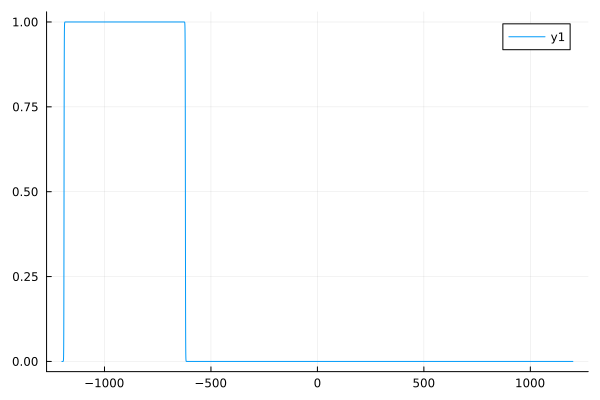

In [48]:
# define sigma function
k_1 = 1
f_1 = 1

ℓ1 = -L + (L/2) - 10
ℓ2 = L - 5
σ = x -> 1 .- (0.5.*(tanh.((x.-ℓ1)) .+ 1) + 0.5.*(tanh.((-x.-ℓ2)) .+ 1))

Σ = Diagonal(σ(X))
A = x -> x + (dt/2)*D*mfft(Σ*mifft(D*x))
B = x -> x - (dt/2)*D*mfft(Σ*mifft(D*x));
plot(X, σ(X))

In [75]:
# calculate width of sigma 
start = 0
ending = 0
x1 = 0
x2 = 0

for x in X
    if σ(x) == 1 && start == 0
        x1 = x
        start = 1
    end
    if σ(x) == 0 && start == 1
        x2 = x
        break
    end
end

ω = x2 - x1

1239.92919921875

## Solution approximated with a sum

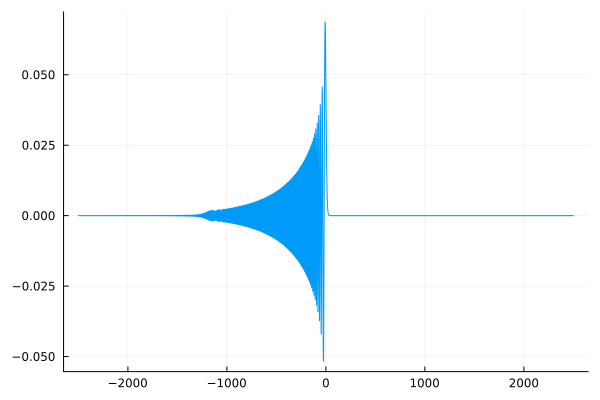

In [76]:
f = k -> exp.(-k .^ 2)
ck = 0 # center of wave packet
σ0 = 1 # height of sigma
ϵ = exp(-σ0 * ω) # magnitude of damping
T = 150
P_ = abs(x2) # where the damping starts

Q = zeros(length(X))
for i = 1:length(X)
    j = n[i]
    kj = (pi / L) * j
    if abs(3 * kj ^ 2 * T - ck) < P_
        Q += (1 / (2*L)) * exp.(1im * (kj * X .+ kj ^ 3 * T)) * f(kj)
    else
        Q += (ϵ / (2*L)) * exp.(1im * (kj * X .+ kj ^ 3 * T)) * f(kj)
    end
end
plot(X, Q |> real, label = false)

## Numerical Solution

In [77]:
D = (pi/L) * Diagonal(1im.*n);

In [78]:
M = D.^3
F = c -> 0 .* c; # no nonlinear term in linearized kdv

In [79]:
k = j -> j * pi / L

#107 (generic function with 1 method)

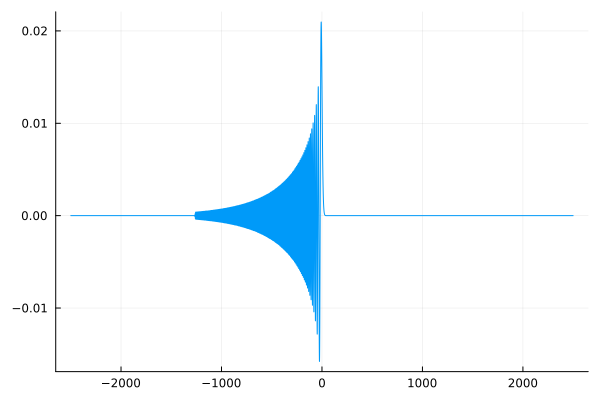

In [80]:
c = f(k(n)) # fourier coefficents of IC
dt = 0.01
T = 150
t = 0.0
steps = convert(Int64,ceil(T/dt))
a = c

for i = 1:steps+1   
    if isinteger(i / f_1)
        # Heat equation with Strang-splitting:
        a = rk4(c,0,dt/2)
        c_til = exp(-M*dt/2) * a
        c_bar = CG(B, A(c_til), 1e-10)
        a = rk4(c_bar,0,dt/2)
        c = exp(-M*dt/2) * a
    else
        a = rk4(c,0,dt)
        c = exp(-M*dt) * a
    end
    
    t += dt
end

final_solution = mifft(c) |> real;
plot(X, final_solution, label = false)

## Figuring out what to rescale the numerical solution by:

In [81]:
maximum(Q |> real) / maximum(final_solution)

3.2776669500257554

In [82]:
m/L / 2

3.2768

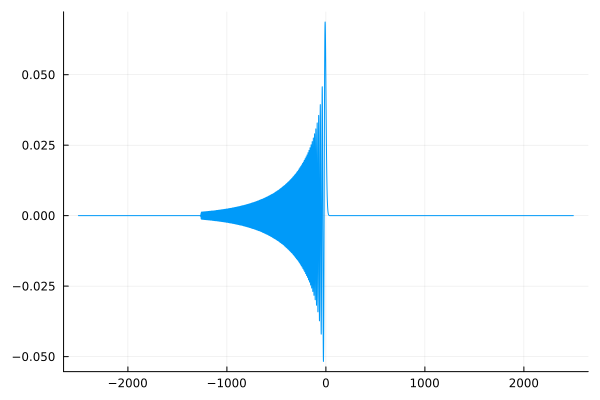

In [83]:
plot(X, final_solution * m / (2*L), label = false)

## Compare approximation with numerical method

In [84]:
error = maximum(abs.((final_solution * m / (2*L)) .- Q))

0.0007547624776415186

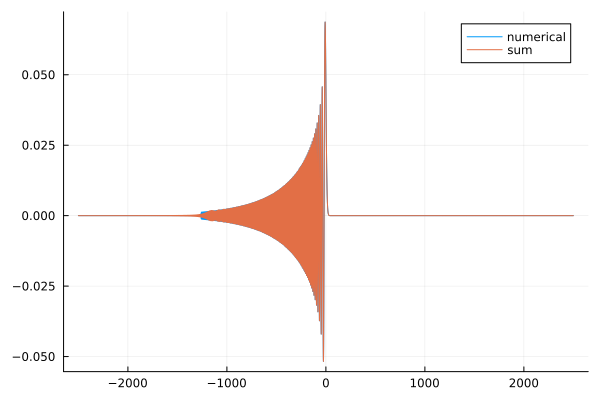

In [85]:
plot(X, final_solution * m / (2*L), label = "numerical")
plot!(X, Q |> real, label = "sum")

In [86]:
# We can only expect our solutions to match outside of the damping region,
# so let's calculate the error on this interval.
ind = 0
for i = 1:length(X)
    if X[i] > x2
        ind = i
        break
    end
end

error = maximum(abs.((final_solution[ind:length(final_solution)] * m / (2*L)) .- Q[ind:length(final_solution)]))

0.0006184042689524828

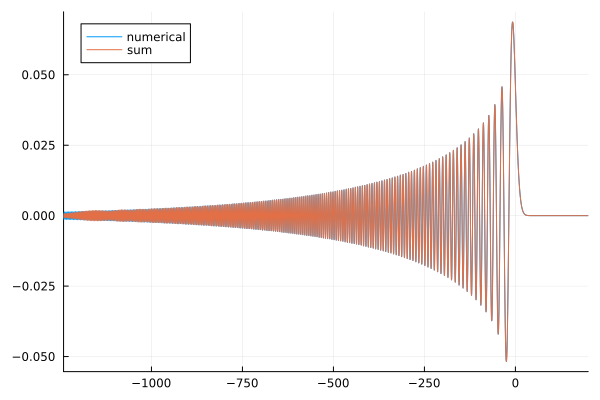

In [87]:
plot(X, final_solution * m / (2*L), label = "numerical", xaxis = [x2,200])
plot!(X, Q |> real, label = "sum")